In this notebook, we will be implementing Fast R-CNN model from scratch and train on PASCAL VOC 2007 dataset 

This model was trained without transforming the bounduing box offsets, therefore, if we want to use this model again, then we need to re-train the model and evaluate 

#### Importing necessary libraies 

In [1]:
import torch
import cv2
import pickle
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
from PIL import Image
import torch.nn.functional as F

In [51]:
# loading detection data
voc_dataset_train = torchvision.datasets.VOCDetection(root="content/voc",
                                                image_set="train",
                                                download=True,
                                                year="2007")
voc_dataset_val = torchvision.datasets.VOCDetection(root="content/voc",
                                                image_set="val",
                                                download=True,
                                                year="2007")

Using downloaded and verified file: content/voc\VOCtrainval_06-Nov-2007.tar
Extracting content/voc\VOCtrainval_06-Nov-2007.tar to content/voc
Using downloaded and verified file: content/voc\VOCtrainval_06-Nov-2007.tar
Extracting content/voc\VOCtrainval_06-Nov-2007.tar to content/voc


In [3]:
print(f"Total sample in training data: {len(voc_dataset_train)}")
print(f"Total sample in validation data: {len(voc_dataset_val)}")

Total sample in training data: 2501
Total sample in validation data: 2510


In [ ]:
# data path 
# DON'T RUN
processed_fast_train = "fast-rcnn/rcnn_train/fast_rcnn_train"
processed_fast_val = "fast-rcnn/rcnn_val/fast_rcnn_val"

# create directory
os.makedirs(processed_fast_train, exist_ok=True)
os.makedirs(processed_fast_val, exist_ok=True)

#  checking the total samples in both train and validation after applying selective search  
print(f"Total objects in training samples after Selective search: {len(os.listdir(processed_fast_train))}")
print(f"Total objects in validation samples after selectective search: {len(os.listdir(processed_fast_val))}")

In [2]:
# calculate IoU
def intersection_over_union(boxes_preds, boxes_labels, box_format="corners"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    # Slicing idx:idx+1 in order to keep tensor dimensionality
    # Doing ... in indexing if there would be additional dimensions
    # Like for Yolo algorithm which would have (N, S, S, 4) in shape
    # Ensure inputs are tensors
    # Convert to tensor if necessary
    if isinstance(boxes_preds, (list, np.ndarray)):
        boxes_preds = torch.tensor(boxes_preds)
    if isinstance(boxes_labels, (list, np.ndarray)):
        boxes_labels = torch.tensor(boxes_labels)
    
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [3]:
import os
import numpy as np
import cv2
import pickle
from tqdm import tqdm
from PIL import Image

def save_preprocessed_data(dataset, output_dir, max_selections=200):
    for idx, (image, target) in tqdm(enumerate(dataset)):
        # Extract image and target information
        img_id = f"image_{idx:05d}"  # Unique identifier
        image_path = os.path.join(output_dir, f"{img_id}.jpg")

        # Convert the image for saving
        pil_image = image  # Convert tensor back to PIL for saving
        pil_image.save(image_path)

        # Extract bounding boxes, labels, and ground truth from the target
        annotations = target['annotation']
        bounding_boxes = []
        labels = []
        
        for obj in annotations['object']:
            label = obj['name']
            bbox = obj['bndbox']
            bounding_boxes.append([int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])])
            labels.append(label)

        # Generate region proposals using Selective Search
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(np.array(image))  # Using image for proposal generation
        ss.switchToSelectiveSearchFast()
        rects = ss.process()[:max_selections]  # Get up to `max_selections` proposals
        proposals = np.array([[x, y, x + w, y + h] for x, y, w, h in rects])

        # For each proposal, compute IoU with ground truth bounding boxes
        assigned_labels = []
        assigned_bboxes = []
        for proposal in proposals:
            ious = [intersection_over_union(proposal, bbox, box_format="corners") for bbox in bounding_boxes]
            max_iou = max(ious)
            if max_iou >= 0.5:  # Foreground (positive match)
                assigned_labels.append(labels[ious.index(max_iou)])  # Class label for this proposal
                assigned_bboxes.append(bounding_boxes[ious.index(max_iou)])  # Associated ground truth bbox
            else:  # Background (negative match)   # 0.1 <= max_iou < 0.5
                assigned_labels.append('background')
                assigned_bboxes.append(proposal)  # Proposals not matching any object are background

        # Save the image, bounding boxes, labels, and proposals with pickle
        metadata = {
            'image_path': image_path,
            'bounding_boxes': bounding_boxes,
            'labels': labels,
            'proposals': proposals.tolist(),
            'assigned_labels': assigned_labels,
            'assigned_bboxes': assigned_bboxes
        }

        metadata_path = os.path.join(output_dir, f"{img_id}.pkl")
        with open(metadata_path, 'wb') as f:  # Use 'wb' mode for pickle
            pickle.dump(metadata, f)


In [ ]:
# saving training data

# training
save_preprocessed_data(voc_dataset_train, processed_fast_train, max_selections=300)

In [ ]:
# validation
save_preprocessed_data(voc_dataset_val, processed_fast_val, max_selections=300)

In [4]:
# data path 
processed_fast_train = "fast-rcnn/rcnn_train/fast_rcnn_train"
processed_fast_val = "fast-rcnn/rcnn_val/fast_rcnn_val"

#  checking the total samples in both train and validation after applying selective search  
print(f"Total objects in training samples after Selective search: {len(os.listdir(processed_fast_train))}")
print(f"Total objects in validation samples after selectective search: {len(os.listdir(processed_fast_val))}")

Total objects in training samples after Selective search: 5002
Total objects in validation samples after selectective search: 5020


In [5]:
"""
We create two dictionaries to map objects into class indexes, which is also known for labeling. Each type of objects will have a specific class indexes.
It will be helpful for both training and furthur usage. 
"""

obj_to_idx = {
    'pottedplant': 1, 'person': 2,
    'motorbike': 3, 'train': 4,
    'dog': 5, 'diningtable': 6,
    'horse': 7, 'bus': 8,
    'aeroplane': 9, 'sofa': 10,
    'sheep': 11, 'tvmonitor': 12,
    'bird': 13, 'bottle': 14,
    'chair': 15, 'cat': 16,
    'bicycle': 17, 'cow': 18,
    'boat': 19, 'car': 20, 'background': 0
}

idx_to_obj = {
    1: 'pottedplant', 2: 'person',
    3: 'motorbike', 4: 'train',
    5: 'dog', 6: 'diningtable',
    7: 'horse', 8: 'bus',
    9: 'aeroplane', 10: 'sofa',
    11: 'sheep', 12: 'tvmonitor',
    13: 'bird', 14: 'bottle',
    15: 'chair', 16: 'cat',
    17: 'bicycle', 18: 'cow',
    19: 'boat', 20: 'car', 0: 'background'
}


In [13]:
# def calculate_bbox_offsets(pred_bbox, gt_bbox):
#     """
#     Calculate bounding box regression targets (offsets).
#     Args:
#         pred_bbox (list): Predicted bounding box (x, y, w, h).
#         gt_bbox (list): Ground truth bounding box (xmin, ymin, xmax, ymax).
#     Returns:
#         offsets (list): Bounding box regression offsets.
#     """
#     pred_x, pred_y, pred_w, pred_h = pred_bbox
#     gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_bbox

#     # Convert gt_bbox to (x, y, w, h)
#     gt_x = (gt_xmin + gt_xmax) / 2
#     gt_y = (gt_ymin + gt_ymax) / 2
#     gt_w = gt_xmax - gt_xmin
#     gt_h = gt_ymax - gt_ymin

#     # Calculate offsets (normalized)
#     dx = (gt_x - pred_x) / pred_w
#     dy = (gt_y - pred_y) / pred_h
#     dw = np.log(gt_w / pred_w)
#     dh = np.log(gt_h / pred_h)

#     return [dx, dy, dw, dh]

In [6]:
import torch
import numpy as np

def calculate_bbox_offsets(pred_bbox, gt_bbox):
    """
    Calculate bounding box regression targets (offsets).
    Args:
        pred_bbox (torch.Tensor or np.ndarray): Predicted bounding box (x, y, w, h).
        gt_bbox (torch.Tensor or np.ndarray): Ground truth bounding box (xmin, ymin, xmax, ymax).
    Returns:
        offsets (torch.Tensor or np.ndarray): Bounding box regression offsets.
    """
    # Check if inputs are tensors or arrays
    if isinstance(pred_bbox, torch.Tensor):
        is_torch = True
    else:
        is_torch = False

    # Extract coordinates and sizes
    pred_x, pred_y, pred_w, pred_h = pred_bbox
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_bbox

    # Convert gt_bbox to (x, y, w, h)
    gt_x = (gt_xmin + gt_xmax) / 2
    gt_y = (gt_ymin + gt_ymax) / 2
    gt_w = gt_xmax - gt_xmin
    gt_h = gt_ymax - gt_ymin

    # Calculate offsets
    dx = (gt_x - pred_x) / pred_w
    dy = (gt_y - pred_y) / pred_h
    dw = np.log(gt_w / pred_w) if not is_torch else torch.log(gt_w / pred_w)
    dh = np.log(gt_h / pred_h) if not is_torch else torch.log(gt_h / pred_h)

    # Return the offsets as torch.Tensor or np.ndarray
    if is_torch:
        return torch.stack([dx, dy, dw, dh])  # Returning a tensor
    else:
        return np.array([dx, dy, dw, dh])  # Returning a numpy array


In [7]:
# FUNCTION TO DECODE THE PREDICTED BOUNDING BOXES
import numpy as np

def decode_bbox_offsets(proposals, bbox_offsets):
    """
    Decode bounding box offsets to real bounding box values.
    Args:
        proposals (ndarray or list): Proposed regions (x, y, w, h). Can be a single box [4,] or multiple boxes [N, 4].
        bbox_offsets (ndarray or list): Predicted bounding box offsets (dx, dy, dw, dh). Same shape as proposals.
    Returns:
        decoded_boxes (ndarray): Decoded bounding boxes (xmin, ymin, xmax, ymax) in numpy array of shape [N, 4].
    """
    # Ensure inputs are NumPy arrays
    proposals = np.array(proposals)
    bbox_offsets = np.array(bbox_offsets)

    # Check if the input is a single box or multiple boxes
    if proposals.ndim == 1:
        proposals = proposals[np.newaxis, :]  # Convert single box to a batch (1, 4)
    if bbox_offsets.ndim == 1:
        bbox_offsets = bbox_offsets[np.newaxis, :]  # Convert single offset to a batch (1, 4)

    # Extract the components of the proposals and offsets
    pred_x, pred_y, pred_w, pred_h = proposals[:, 0], proposals[:, 1], proposals[:, 2], proposals[:, 3]
    dx, dy, dw, dh = bbox_offsets[:, 0], bbox_offsets[:, 1], bbox_offsets[:, 2], bbox_offsets[:, 3]

    # debugging
    # print("Proposals (x, y, w, h):", pred_x, pred_y, pred_w, pred_h)
    # print("Offsets (dx, dy, dw, dh):", dx, dy, dw, dh)
    # print("Exp(dw):", np.exp(dw))
    # print("Exp(dh):", np.exp(dh))

    # Decode (x, y) from center offset
    decoded_x = pred_x + dx * pred_w
    decoded_y = pred_y + dy * pred_h

    # Decode (w, h) from width and height offset
    decoded_w = pred_w * np.exp(dw)
    decoded_h = pred_h * np.exp(dh)

    # print(f"Decoded values: x:{decoded_x}, y:{decoded_y}, w:{decoded_w}, h:{decoded_h}")

    # Convert back to (xmin, ymin, xmax, ymax)
    xmin = decoded_x - decoded_w / 2
    ymin = decoded_y - decoded_h / 2
    # xmax = decoded_x + decoded_w / 2
    # ymax = decoded_y + decoded_h / 2
    xmax = decoded_w    # it should be devided by 2, but in our encoding we did not devide therefore, here are keeping as it is 
    ymax = decoded_h
    

    # Stack the decoded bounding boxes together (N, 4)
    decoded_boxes = np.stack([xmin, ymin, xmax, ymax], axis=1)

    return decoded_boxes


In [8]:
# loading dataset
from torch.utils.data import Dataset
class FastRCNNDatasetPickle(Dataset):
    def __init__(self, metadata_files, transform=None, label_mapping=obj_to_idx):
        """
        Args:
            metadata_files: List of paths to .pkl metadata files.
            transform: Transformations to apply to images.
            label_mapping: Optional mapping for string labels to integers.
        """
        self.metadata_files = metadata_files
        self.transform = transform
        self.label_mapping = label_mapping
        self.total_proposals = self._calculate_total_proposals()

    def __len__(self):
        return len(self.metadata_files)

    def len_files(self):
        return self.total_proposals

    def _calculate_total_proposals(self):
        total = 0
        for metadata_path in self.metadata_files:
            with open(metadata_path, 'rb') as f:
                metadata = pickle.load(f)
            total += len(metadata['proposals'])
        return total

    def __getitem__(self, idx):
        metadata_path = self.metadata_files[idx]

        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)

        image = Image.open(metadata['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)

        proposals = torch.tensor(metadata['proposals'], dtype=torch.float32)
        # Debugging: Print the shape of the proposals for this sample
        # print(f"Proposals shape for {metadata['image_path']}: {proposals.shape}")
        
        # Map labels if necessary
        if self.label_mapping:
            labels = [self.label_mapping[label] for label in metadata['assigned_labels']]
        else:
            labels = metadata['assigned_labels']
        labels = torch.tensor(labels, dtype=torch.long)

        bbox_offsets = np.array(metadata['assigned_bboxes'], dtype=np.float32)  # Convert to numpy array first
        bbox_offsets = torch.tensor(bbox_offsets)  # Convert numpy array to torch tensor

        # bbox_offsets = torch.tensor(metadata['assigned_bboxes'], dtype=torch.float32)
        # print(f"Labels shape for {metadata['image_path']}: {labels.shape}")
        # print(f"Bounding box offsets shape for {metadata['image_path']}: {bbox_offsets.shape}")

        return image, proposals, labels, bbox_offsets


In [8]:
# # Example: Test Dataset
# # Define any necessary transformations
# from torchvision import transforms
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# train_data = FastRCNNDatasetPickle(metadata_files=train_metadata, transform= transform)

# # Check total proposals and files
# print(f"Total proposals: {len(train_data)}")
# print(f"Total metadata files: {train_data.len_files()}")

In [ ]:
# # Test first few samples
# for idx in range(len(train_data)):
#     image, proposal, label, bbox_offset = train_data[idx]
#     # print(f"Sample {idx}: Proposal: {proposal}, Label: {label}, Offset: {bbox_offset}")


In [ ]:
# from torch.utils.data import DataLoader

# train_loader = DataLoader(
#     train_data,
#     batch_size=8,
#     shuffle=True  # Start with 0 workers for debugging
# )

# # Debug: Check data loading
# for i, (images, proposals, labels, bbox_offsets) in enumerate(train_loader):
#     print(f"Batch {i}:")
#     print(f"Images: {images.shape}")
#     print(f"Proposals: {proposals.shape}")
#     print(f"Labels: {labels.shape}")
#     print(f"Box offsets: {bbox_offsets.shape}")
#     break  # Check only the first batch


In [9]:
import os
import glob

train_folder = processed_fast_train
val_folder = processed_fast_val

train_metadata = glob.glob(os.path.join(train_folder, "*.pkl"))
val_metadata = glob.glob(os.path.join(val_folder, "*.pkl"))

print(f"Total training files: {len(train_metadata)}")
print(f"Total validation files: {len(val_metadata)}")


Total training files: 2501
Total validation files: 2510


In [ ]:
# dataset = FastRCNNDatasetPickle(metadata_files=[train_folder+ '/image_00000.pkl', val_folder + '/image_00000.pkl'])
# print(f"Dataset length: {len(dataset)}")
# print(dataset[0])  # Access first proposal


In [10]:
from torchvision import transforms

# Define any necessary transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create the dataset instance
train_data =FastRCNNDatasetPickle(metadata_files=train_metadata, transform=transform)
valid_data = FastRCNNDatasetPickle(metadata_files=val_metadata, transform=transform)

print(f"Total samples in the training data: {len(train_data)}")
print(f"Total samples in the validation set: {len(valid_data)}")
print(f"Total train metadata (proposals) files: {train_data.len_files()}")
print(f"Total validation metadata (proposals) files: {valid_data.len_files()}")

Total samples in the training data: 2501
Total samples in the validation set: 2510
Total train metadata (proposals) files: 745998
Total validation metadata (proposals) files: 750391


In [ ]:
train_data[0]

In [ ]:
# from torch.utils.data import DataLoader
# import torch.nn.functional as F
# # TO HANDLE LESS DATA THAN EXPECTED

# import torch
# import torch.nn.functional as F

# def collate_fn(batch):
#     images, proposals, labels, bbox_offsets = zip(*batch)

#     max_proposals = 300  # Ensure all proposals have the same number (300 in this case)

#     # Pad proposals if they are less than 300
#     padded_proposals = [F.pad(proposal, (0, 0, 0, max_proposals - proposal.size(0)), "constant", 0) 
#                         if proposal.size(0) < max_proposals else proposal for proposal in proposals]

#     # Pad labels and bbox_offsets to match the number of proposals (300)
#     padded_labels = [F.pad(label, (0, max_proposals - label.size(0)), "constant", 0) 
#                      if label.size(0) < max_proposals else label for label in labels]
    
#     padded_bbox_offsets = [F.pad(offset, (0, 0, 0, max_proposals - offset.size(0)), "constant", 0) 
#                            if offset.size(0) < max_proposals else offset for offset in bbox_offsets]

#     # Now stack the padded tensors
#     return torch.stack(images, 0), torch.stack(padded_proposals, 0), torch.stack(padded_labels, 0), torch.stack(padded_bbox_offsets, 0)

# # Pass collate_fn to DataLoader
# train_loader = DataLoader(train_data, batch_size=8, collate_fn=collate_fn)


In [ ]:
for i, (images, proposals, labels, bbox_offsets) in enumerate(train_loader):
    print(f"Number of proposals in batch {i}: {proposals.shape[1]}")


In [11]:
from torch.utils.data import DataLoader


def collate_fn(batch):
    images, proposals, labels, bbox_offsets = zip(*batch)

    max_proposals = 300  # Ensure all proposals have the same number (300 in this case)

    # Pad proposals if they are less than 300
    padded_proposals = [F.pad(proposal, (0, 0, 0, max_proposals - proposal.size(0)), "constant", 0) 
                        if proposal.size(0) < max_proposals else proposal for proposal in proposals]

    # Pad labels and bbox_offsets to match the number of proposals (300)
    padded_labels = [F.pad(label, (0, max_proposals - label.size(0)), "constant", 0) 
                     if label.size(0) < max_proposals else label for label in labels]
    
    padded_bbox_offsets = [F.pad(offset, (0, 0, 0, max_proposals - offset.size(0)), "constant", 0) 
                           if offset.size(0) < max_proposals else offset for offset in bbox_offsets]

    # Now stack the padded tensors
    return torch.stack(images, 0), torch.stack(padded_proposals, 0), torch.stack(padded_labels, 0), torch.stack(padded_bbox_offsets, 0)

batch_size = 8
num_workers = 0  # Number of data loading threads

train_loader = DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    collate_fn=collate_fn
)

print(f"Total batches in tain loader: {len(train_loader)}")
print(f"Total batches in validation loader: {len(valid_loader)}")

Total batches in tain loader: 313
Total batches in validation loader: 314


In [19]:
for i, (images, proposals, labels, bbox_offsets) in enumerate(train_loader):
    print(f"Number of proposals in batch {i}: {proposals.shape[1]}")
    print(f"Type of proposals {i}: {type(proposals)}")
    print(f"Shape of each proposals {i}: {proposals.shape}")
    print(f"Image Shape {i}: {images.shape}")
    print(f"Labels Shape {i}: {labels.shape}")
    print(f"Bounding Box Shape {i}: {bbox_offsets.shape}")


Number of proposals in batch 0: 300
Type of proposals 0: <class 'torch.Tensor'>
Shape of each proposals 0: torch.Size([8, 300, 4])
Image Shape 0: torch.Size([8, 3, 224, 224])
Labels Shape 0: torch.Size([8, 300])
Bounding Box Shape 0: torch.Size([8, 300, 4])
Number of proposals in batch 1: 300
Type of proposals 1: <class 'torch.Tensor'>
Shape of each proposals 1: torch.Size([8, 300, 4])
Image Shape 1: torch.Size([8, 3, 224, 224])
Labels Shape 1: torch.Size([8, 300])
Bounding Box Shape 1: torch.Size([8, 300, 4])
Number of proposals in batch 2: 300
Type of proposals 2: <class 'torch.Tensor'>
Shape of each proposals 2: torch.Size([8, 300, 4])
Image Shape 2: torch.Size([8, 3, 224, 224])
Labels Shape 2: torch.Size([8, 300])
Bounding Box Shape 2: torch.Size([8, 300, 4])
Number of proposals in batch 3: 300
Type of proposals 3: <class 'torch.Tensor'>
Shape of each proposals 3: torch.Size([8, 300, 4])
Image Shape 3: torch.Size([8, 3, 224, 224])
Labels Shape 3: torch.Size([8, 300])
Bounding Box S

In [20]:
for i, (images, proposals, labels, bbox_offsets) in enumerate(valid_loader):
    print(f"Number of proposals in batch {i}: {proposals.shape[1]}")
    print(f"Image Shape {i}: {images.shape}")
    print(f"Labels Shape {i}: {labels.shape}")
    print(f"Bounding Box Shape {i}: {bbox_offsets.shape}")


Number of proposals in batch 0: 300
Image Shape 0: torch.Size([8, 3, 224, 224])
Labels Shape 0: torch.Size([8, 300])
Bounding Box Shape 0: torch.Size([8, 300, 4])
Number of proposals in batch 1: 300
Image Shape 1: torch.Size([8, 3, 224, 224])
Labels Shape 1: torch.Size([8, 300])
Bounding Box Shape 1: torch.Size([8, 300, 4])
Number of proposals in batch 2: 300
Image Shape 2: torch.Size([8, 3, 224, 224])
Labels Shape 2: torch.Size([8, 300])
Bounding Box Shape 2: torch.Size([8, 300, 4])
Number of proposals in batch 3: 300
Image Shape 3: torch.Size([8, 3, 224, 224])
Labels Shape 3: torch.Size([8, 300])
Bounding Box Shape 3: torch.Size([8, 300, 4])
Number of proposals in batch 4: 300
Image Shape 4: torch.Size([8, 3, 224, 224])
Labels Shape 4: torch.Size([8, 300])
Bounding Box Shape 4: torch.Size([8, 300, 4])
Number of proposals in batch 5: 300
Image Shape 5: torch.Size([8, 3, 224, 224])
Labels Shape 5: torch.Size([8, 300])
Bounding Box Shape 5: torch.Size([8, 300, 4])
Number of proposals in

In [21]:
for i, (images, proposals, labels, bbox_offsets) in enumerate(train_loader):
    print(f"Sample proposals {i}: {proposals}")

Sample proposals 0: tensor([[[ 88., 217., 112., 264.],
         [400., 282., 500., 399.],
         [275., 133., 288., 153.],
         ...,
         [292.,  20., 331.,  47.],
         [ 17., 358.,  40., 372.],
         [276., 346., 319., 371.]],

        [[ 34., 430., 112., 500.],
         [ 32., 316., 199., 500.],
         [297., 161., 318., 169.],
         ...,
         [175., 188., 195., 199.],
         [ 57.,  61., 141., 118.],
         [155., 316., 172., 351.]],

        [[128.,  10., 244.,  22.],
         [  0.,  75., 315.,  94.],
         [319., 174., 447., 202.],
         ...,
         [394., 272., 465., 279.],
         [  0., 244., 311., 331.],
         [  0., 309., 146., 325.]],

        ...,

        [[215., 166., 252., 193.],
         [387., 131., 415., 142.],
         [410.,  53., 477., 217.],
         ...,
         [362.,  90., 386., 132.],
         [472., 263., 500., 274.],
         [205., 131., 452., 289.]],

        [[242., 215., 480., 345.],
         [165.,  52., 186.,

In [76]:
for i, (images, proposals, labels, bbox_offsets) in enumerate(train_loader):
    print(f"Sample proposals {i}: {bbox_offsets}")

Sample proposals 0: tensor([[[155., 224., 294., 375.],
         [255., 148., 267., 196.],
         [128., 110., 284., 182.],
         ...,
         [140., 312., 158., 327.],
         [331., 345., 342., 375.],
         [371., 341., 430., 375.]],

        [[ 58., 183., 139., 191.],
         [193.,  12., 256.,  34.],
         [123., 309., 152., 320.],
         ...,
         [  0.,  38., 208.,  95.],
         [ 58., 102., 160., 113.],
         [166.,  38., 222.,  53.]],

        [[251.,  78., 369.,  88.],
         [190., 199., 215., 255.],
         [ 44., 224.,  60., 256.],
         ...,
         [291., 160., 321., 174.],
         [  0.,  25., 177.,  51.],
         [  0., 195.,  55., 276.]],

        ...,

        [[266., 329., 361., 373.],
         [168.,   0., 197.,  17.],
         [322.,  65., 361.,  75.],
         ...,
         [249., 402., 277., 420.],
         [  0., 427., 238., 500.],
         [215., 434., 236., 459.]],

        [[240., 158., 320., 229.],
         [318., 202., 408.,

In [71]:
for i, (images, proposals, labels, bbox_offsets) in enumerate(train_loader):
    print(f"Sample proposals {i}: {labels.unique()}")

Sample proposals 0: tensor([ 0,  2,  5, 10, 13, 14, 16])
Sample proposals 1: tensor([ 0,  1,  2,  5,  7, 11, 13, 20])
Sample proposals 2: tensor([ 0,  2,  5,  7, 11, 13, 16, 19])
Sample proposals 3: tensor([ 0,  2,  4,  5, 10, 15])
Sample proposals 4: tensor([ 0,  1,  2, 14, 15, 16, 17, 20])
Sample proposals 5: tensor([ 0,  1,  2,  6, 10, 13, 15, 20])
Sample proposals 6: tensor([ 0,  2,  3,  6,  9, 14, 15, 16, 17])
Sample proposals 7: tensor([ 0,  1,  2, 10, 12, 13, 15, 16, 17, 18])
Sample proposals 8: tensor([ 0,  2,  7,  9, 10, 13, 16, 19])
Sample proposals 9: tensor([ 0,  2,  3,  8, 16, 19, 20])
Sample proposals 10: tensor([ 0,  2,  7, 12, 14, 15, 16, 20])
Sample proposals 11: tensor([ 0,  2,  4,  7,  8, 12, 13, 15, 17, 19, 20])
Sample proposals 12: tensor([ 0,  2,  3,  4,  5,  7, 10, 12])
Sample proposals 13: tensor([ 0,  2,  5,  6,  9, 10, 13, 15, 18, 20])
Sample proposals 14: tensor([ 0,  2,  3, 10, 11, 14, 15, 17, 19, 20])
Sample proposals 15: tensor([ 0,  2,  3,  5, 10, 12, 13,

In [23]:
def calculate_bbox_offsets_batch(proposals, gt_bboxes):
    """
    Calculate bounding box regression targets (offsets) for batched proposals and ground truth boxes.
    Args:
        proposals (torch.Tensor): Predicted bounding boxes in [xmin, ymin, xmax, ymax] format with shape [batch_size, num_proposals, 4].
        gt_bboxes (torch.Tensor): Ground truth boxes in [xmin, ymin, xmax, ymax] format with shape [batch_size, num_proposals, 4].
    Returns:
        offsets (torch.Tensor): Bounding box regression offsets with shape [batch_size, num_proposals, 4].
    """
    # Convert proposals from [xmin, ymin, xmax, ymax] to [x, y, w, h]
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = proposals.unbind(dim=-1)
    pred_x = (pred_xmin + pred_xmax) / 2
    pred_y = (pred_ymin + pred_ymax) / 2
    pred_w = pred_xmax - pred_xmin
    pred_h = pred_ymax - pred_ymin

    # Convert ground truth from [xmin, ymin, xmax, ymax] to [x, y, w, h]
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_bboxes.unbind(dim=-1)
    gt_x = (gt_xmin + gt_xmax) / 2
    gt_y = (gt_ymin + gt_ymax) / 2
    gt_w = gt_xmax - gt_xmin
    gt_h = gt_ymax - gt_ymin

    # Calculate offsets
    dx = (gt_x - pred_x) / pred_w
    dy = (gt_y - pred_y) / pred_h
    dw = torch.log(gt_w / pred_w)
    dh = torch.log(gt_h / pred_h)

    return torch.stack([dx, dy, dw, dh], dim=-1)


In [ ]:
def decode_bbox_offsets(proposals, bbox_offsets):
    """
    Decode bounding box offsets to the final bounding box predictions.
    Args:
        proposals (torch.Tensor): Proposals in [xmin, ymin, xmax, ymax] format, shape (batch_size, num_boxes, 4).
        bbox_offsets (torch.Tensor): Predicted offsets [dx, dy, dw, dh], shape (batch_size, num_boxes, 4).
    Returns:
        decoded_boxes (torch.Tensor): Decoded bounding boxes in [xmin, ymin, xmax, ymax] format, shape (batch_size, num_boxes, 4).
    """
    # Split proposals into components
    xmin, ymin, xmax, ymax = proposals.split(1, dim=-1)

    # Convert proposals to center-size format
    px = (xmin + xmax) / 2
    py = (ymin + ymax) / 2
    pw = xmax - xmin
    ph = ymax - ymin

    # Split bbox_offsets into components
    dx, dy, dw, dh = bbox_offsets.split(1, dim=-1)

    # Decode offsets to center-size format
    pred_x = dx * pw + px
    pred_y = dy * ph + py
    pred_w = pw * torch.exp(dw)
    pred_h = ph * torch.exp(dh)

    # Convert decoded boxes back to corner-size format
    decoded_xmin = pred_x - pred_w / 2
    decoded_ymin = pred_y - pred_h / 2
    decoded_xmax = pred_x + pred_w / 2
    decoded_ymax = pred_y + pred_h / 2

    # Stack the components to form final boxes
    decoded_boxes = torch.cat([decoded_xmin, decoded_ymin, decoded_xmax, decoded_ymax], dim=-1)
    return decoded_boxes


#### Developing Fas R-CNN Model

In [12]:
# defining device 
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
# defining feature extractor
import torch
import torchvision.models as models
import torch.nn as nn

class BackboneExtractor(nn.Module):
    def __init__(self, backbone_type="vgg16"):
        super(BackboneExtractor, self).__init__()

        if backbone_type == "vgg16":
            # Use pre-trained VGG16 as backbone
            vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
            self.backbone = nn.Sequential(*list(vgg16.features.children()))
        elif backbone_type.startswith("resnet"):
            # Use pre-trained ResNet as backbone
            resnet = models.__dict__[backbone_type](pretrained=True, weights='IMAGENET1K_V2')
            self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Removing the fully connected layers
        else:
            raise ValueError("Unsupported backbone type. Use 'vgg16' or 'resnet' family.")
        
    def forward(self, x):
        return self.backbone(x)

In [14]:
class ROI_Pool(nn.Module):
    def __init__(self, size, mode='max'):
        """
        Args:
            size: Tuple (output_height, output_width) for the pooled region size
            mode: Pooling mode, either 'max' or 'avg'
        """
        super(ROI_Pool, self).__init__()
        self.pool_size = size
        self.pool_mode = mode
        assert mode in ['max', 'avg'], "Pooling mode must be 'max' or 'avg'"

    def forward(self, feature_maps, rois):
        """
        Args:
            feature_maps: Tensor of shape (batch_size, channels, height, width)
            rois: Tensor of shape (batch_size, num_proposals, 4) with (x1, y1, x2, y2)
        Returns:
            pooled_features: Tensor of shape (batch_size * num_proposals, channels, pool_size[0], pool_size[1])
        """
        batch_size, channels, height, width = feature_maps.shape
        num_proposals = rois.size(1)

        pooled_features_list = []  # Store pooled features per image

        for b in range(batch_size):
            pooled_per_image = torch.zeros(
                (num_proposals, channels, *self.pool_size),
                device=feature_maps.device
            )

            for i in range(num_proposals):
                x1, y1, x2, y2 = rois[b, i]

                # Convert coordinates to integer
                x1, x2 = int(torch.floor(x1)), int(torch.ceil(x2))
                y1, y2 = int(torch.floor(y1)), int(torch.ceil(y2))

                # Handle out-of-bounds cases
                x1_src, x2_src = max(0, x1), min(width, x2)
                y1_src, y2_src = max(0, y1), min(height, y2)

                if x1_src < x2_src and y1_src < y2_src:  # Valid region exists
                    region = feature_maps[b, :, y1_src:y2_src, x1_src:x2_src]
                    pool_func = F.adaptive_max_pool2d if self.pool_mode == 'max' else F.adaptive_avg_pool2d
                    pooled = pool_func(region.unsqueeze(0), self.pool_size).squeeze(0)
                    pooled_per_image[i] = pooled
                # Invalid regions remain as zeros (already initialized)

            pooled_features_list.append(pooled_per_image)

        # Concatenate pooled features across the batch (batch_size * num_proposals)
        pooled_features = torch.cat(pooled_features_list, dim=0)

        # Return shape: [batch_size * num_proposals, channels, pool_size[0], pool_size[1]]
        return pooled_features


In [15]:
import torch
import torch.nn as nn

class FastRCNNLoss(nn.Module):
    def __init__(self, cls_weight=1.0, bbox_weight=1.0):
        super(FastRCNNLoss, self).__init__()
        self.cls_weight = cls_weight
        self.bbox_weight = bbox_weight
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.smooth_l1_loss = nn.SmoothL1Loss()

    def forward(self, cls_preds, bbox_preds, cls_labels, bbox_targets):
        """
        Args:
            cls_preds (Tensor): Class predictions (batch_size * num_proposals, num_classes)
            bbox_preds (Tensor): Bounding box predictions (batch_size * num_proposals, 4)
            cls_labels (Tensor): Ground truth class labels (batch_size * num_proposals)
            bbox_targets (Tensor): Ground truth bbox targets (batch_size * num_proposals, 4)
        """
        # Flatten the cls_labels to match the flattened predictions
        cls_labels_flat = cls_labels.view(-1)  # Shape: [batch_size * num_proposals]

        # Class loss (CrossEntropyLoss expects shape [N, C], where N is number of proposals and C is number of classes)
        cls_loss = self.cross_entropy_loss(cls_preds, cls_labels_flat)

        # Bounding box loss (only for positive samples), we are leaving out the background
        # Bounding Box Loss
        pos_mask = cls_labels_flat > 0   # boolean mask
        bbox_preds_flat = bbox_preds.view(-1, 20, 4)
        # print(f"Bounding box preds after flattening: {bbox_preds_flat.shape}")
        bbox_targets_flat = bbox_targets.view(-1, 4)
        # print(f"Bounding box target after flattening: {bbox_targets_flat.shape}")
        # print(f"cls_labels_flat[pos_mask]: {cls_labels_flat[pos_mask]}")

        # Select positive samples
        pos_bbox_preds = bbox_preds_flat[pos_mask]  # Shape: [num_pos_samples, num_classes, 4]
        # print(f"Bounding box preds SHAPE after masking: {pos_bbox_preds.shape}")
        pos_bbox_targets = bbox_targets_flat[pos_mask]  # Shape: [num_pos_samples, 4]
        # print(f"Bounding box targets SHAPE after masking: {pos_bbox_targets.shape}")

        # Select the class-specific predictions
        pos_indices = cls_labels_flat[pos_mask] - 1  # Convert to zero-based indices
        # print(f"Shape of positional indices: {pos_indices.shape}")
        pos_bbox_preds = pos_bbox_preds[torch.arange(pos_bbox_preds.size(0)), pos_indices]  # Shape: [num_pos_samples, 4]
        # print(f"Shape of pos_bounding box preds after the indexing: {pos_bbox_preds.shape}")
        
        # calculate the regression loss
        bbox_loss = self.smooth_l1_loss(pos_bbox_preds, pos_bbox_targets)

        # Total loss
        total_loss = self.cls_weight * cls_loss + self.bbox_weight * bbox_loss
        return total_loss, cls_loss, bbox_loss


In [37]:
# putting altogether to create the Fast RCNN network
class FastRCNN(nn.Module):
    def __init__(self, backbone_type="vgg16", num_classes=20):
        super(FastRCNN, self).__init__()
        
        # Backbone feature extractor (VGG16/ResNet)
        self.backbone = BackboneExtractor(backbone_type=backbone_type)
        
        # ROI Pooling layer
        # self.roi_pooling = RoIPooling()
        self.roipool = ROI_Pool((7, 7))
        
        # Classifier (fully connected layer for classification)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # 512 is for VGG16 feature maps, 7x7 is output size of ROI pooling
            nn.ReLU(),
            nn.Linear(4096, 2048), 
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(2048, num_classes+1)
        )
        
        # Bounding box regressor (fully connected layer for bbox regression)
        self.bbox_regressor = nn.Sequential(
            nn.Linear(512 * 7 * 7, 2048),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(2048, num_classes*4)  # Predicts 4 values for bbox (dx, dy, dw, dh)
        )

    def forward(self, images, rois):
        # Extract features using the backbone
        features = self.backbone(images)
        # print("Feature map size:", features.size()) 
        
        # Perform ROI pooling
        # pooled_rois = self.roi_pooling(features, rois)
        pooled_rois = self.roipool(features, rois)
        # print("Pooled RoI size:", pooled_rois.size()) 
        
        # Flatten pooled ROIs for fully connected layers
        # pooled_rois_flat = pooled_rois.view(pooled_rois.size(0), -1)
        pooled_rois_flat = pooled_rois.view(pooled_rois.size(0), -1)
        # pooled_rois_flat = pooled_rois.view(8 * 300, -1)   # this hardcoded approach will through error for lesser smples in a batch 
        # print("Pooled RoI after flatten size:", pooled_rois_flat.size())
        
        # Class predictions
        cls_preds = self.classifier(pooled_rois_flat)
        
        # Bounding box predictions
        bbox_preds = self.bbox_regressor(pooled_rois_flat)
        
        return cls_preds, bbox_preds


In [38]:
fast_rcnn_model = FastRCNN(backbone_type="vgg16", num_classes=20)
fast_rcnn_model

FastRCNN(
  (backbone): BackboneExtractor(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
!pip install torchmetrics
!pip install torchmetrics[detection]

In [ ]:
!pip install mean_average_precision

In [18]:
# from mean_average_precision import MeanAveragePrecision 
from torchmetrics.detection.mean_ap import MeanAveragePrecision
map_metric = MeanAveragePrecision()

In [ ]:
# # EVALUATION FUNCTION

# def evaluate(model, valid_loader, criterion, device):
#     model.to(device)
#     model.eval()  # Set model to evaluation mode

#     val_loss = 0.0
#     correct = 0
#     total = 0
#     iou_scores = []
#     map_metric = MeanAveragePrecision()  # Initialize mAP metric

#     with torch.no_grad():  # No need to calculate gradients during validation
#         for images, class_labels, bbox_targets in valid_loader:
#             images = images.to(device)
#             class_labels = class_labels.to(device)
            
#             # Ensure bbox_targets is a tensor
#             if isinstance(bbox_targets, list):
#                 bbox_targets = [b.clone().detach().to(device).float() for b in bbox_targets]
#                 bbox_targets = torch.stack(bbox_targets)
#                 bbox_targets = bbox_targets.permute(1, 0)
            
#             bbox_targets = bbox_targets.to(device)

#             # Forward pass
#             class_scores, bbox_offsets = model(images)

#             # Ensure shapes match for bounding boxes
#             assert bbox_offsets.shape == bbox_targets.shape, \
#                 f"Shape mismatch: bbox_offsets {bbox_offsets.shape} vs bbox_targets {bbox_targets.shape}"

#             # Calculate loss
#             loss, cls_loss, bbox_loss = criterion(class_scores, bbox_offsets, class_labels, bbox_targets)
#             val_loss += loss.item()

#             # IoU Calculation (assuming compute_iou_torch returns a list of IoU scores)
#             iou_batch = intersection_over_union(bbox_offsets, bbox_targets)
#             iou_scores.extend(iou_batch.tolist())

#             # Update mAP metric
#             for idx in range(len(class_labels)):
#                 # Ensure valid bounding boxes (clamp and adjust)
#                 bbox_offsets[idx] = torch.clamp(bbox_offsets[idx], min=0.0, max=1.0)
#                 bbox_offsets[idx, 2] = torch.max(bbox_offsets[idx, 0], bbox_offsets[idx, 2])
#                 bbox_offsets[idx, 3] = torch.max(bbox_offsets[idx, 1], bbox_offsets[idx, 3])

#                 bbox_targets[idx] = torch.clamp(bbox_targets[idx], min=0.0, max=1.0)
#                 bbox_targets[idx, 2] = torch.max(bbox_targets[idx, 0], bbox_targets[idx, 2])
#                 bbox_targets[idx, 3] = torch.max(bbox_targets[idx, 1], bbox_targets[idx, 3])

#                 # Convert logits to probabilities (softmax)
#                 class_probs = torch.softmax(class_scores[idx], dim=-1)
                
#                 # Get the probability of the correct class
#                 score = class_probs[class_labels[idx].item()]  # Probability of the correct class

#                 # Update mAP metric
#                 map_metric.update(
#                     preds=[{
#                         "boxes": bbox_offsets[idx].unsqueeze(0),
#                         "scores": score.unsqueeze(0),  # Ensure the score is a tensor of shape (1,)
#                         "labels": class_labels[idx].unsqueeze(0)
#                     }],
#                     target=[{
#                         "boxes": bbox_targets[idx].unsqueeze(0),
#                         "labels": class_labels[idx].unsqueeze(0)
#                     }]
#                 )

#             # Calculate classification accuracy
#             _, predicted = torch.max(class_scores, 1)
#             total += class_labels.size(0)
#             correct += (predicted == class_labels).sum().item()

#     # Calculate average loss and accuracy
#     avg_val_loss = val_loss / len(valid_loader)
#     accuracy = 100 * correct / total
#     mean_iou = sum(iou_scores) / len(iou_scores) if len(iou_scores) > 0 else 0

#     # Compute mAP after the loop over all batches
#     map_results = map_metric.compute()

#     # Extract the overall mAP from the results
#     overall_map = map_results['map'].item()  # Convert to Python float

#     return avg_val_loss, accuracy, mean_iou, overall_map


In [39]:
import torch.optim as optim
from torch.optim import lr_scheduler

fast_rcnn_model.cuda()

num_epochs = 20
lr = 0.0004
# here, we are using default parameters of optimizer 
optimizer = optim.Adam(fast_rcnn_model.parameters(), 
                       lr=lr, betas=(0.7, 0.8), eps=1e-05, weight_decay=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 

In [42]:
import time
import torch
from tqdm import tqdm

def train_fast_rcnn(model, train_loader, num_epochs, lr, optimizer, device):
    model.to(device)

    # Loss function for classification and bbox regression
    criterion = FastRCNNLoss()

    # To keep track of the best model based on training loss
    best_train_loss = float("inf")  # Initialize with a very high value
    best_model_wts = None

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        start_time = time.time()

        # Training Phase
        model.train()
        running_loss = 0.0
        running_cls_loss = 0.0
        running_bbox_loss = 0.0
        correct = 0
        total = 0

        with tqdm(train_loader, unit="batch") as tepoch:
            for i, (images, proposals, labels, gt_bbox) in enumerate(tepoch):
                images = images.to(device)
                proposals = proposals.to(device)
                labels = labels.to(device)
                gt_bbox = gt_bbox.to(device)


                # Convert the The ground truth boxes are in [xmin, ymin, xmax, ymax] format
                bbox_offsets_gt = calculate_bbox_offsets_batch(proposals, gt_bbox)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                class_scores, bbox_offsets_pred = model(images, proposals)
                # print(f"Predicted class score shape: {class_scores.shape}")
                # print(f"BBox offsets after prediction: {bbox_offsets_pred.shape}")

                # # Reshape outputs to batch format for loss computation
                # class_scores = class_scores.view(8, 300, 21)  # Shape: [batch_size, num_proposals, num_classes]
                # bbox_offsets_pred = bbox_offsets_pred.view(8, 300, 20, 4)  # Shape: [batch_size, num_proposals, num_classes * 4]
                # print(f"Predicted class score after reshape: {class_scores.shape}")
                # print(f"BBox offsets after reshape: {bbox_offsets_pred.shape}")

                # # Flatten the class predictions and labels for the loss function
                # cls_preds_flat = class_scores.view(-1, 21)  # Flatten to [batch_size * num_proposals, num_classes]
                # bbox_offsets_pred = bbox_offsets_pred.view(-1, 20 * 4)  # Flatten bbox offsets
                # print(f"BBox offsets after flatten: {cls_preds_flat.shape}")
                # print(f"Class prediction after flatten: {bbox_offsets_pred.shape}")
                # print(f"BBox offsets ground truth: {bbox_offsets.shape}")

                # Compute the loss
                loss, cls_loss, bbox_loss = criterion(
                    class_scores, bbox_offsets_pred, labels.view(-1), bbox_offsets_gt.view(-1, 4)
                )
                # loss, cls_loss, bbox_loss = criterion(
                #     class_scores, bbox_offsets_pred, labels.view(-1), bbox_offsets.view(-1, 4)
                # )

                # Backpropagation and optimization
                loss.backward()
                optimizer.step()

                # Update running metrics
                running_loss += loss.item()
                running_cls_loss += cls_loss.item()
                running_bbox_loss += bbox_loss.item()

                # Accuracy calculation
                _, predicted = torch.max(class_scores, 1)  # Predicted classes
                correct += (predicted == labels.view(-1)).sum().item()  # Compare with flattened labels
                total += labels.size(0) * labels.size(1)  # Total number of proposals (batch_size * num_proposals)

                # Update progress bar
                tepoch.set_postfix(
                    loss=running_loss / (i + 1),
                    cls_loss=running_cls_loss / (i + 1),
                    bbox_loss=running_bbox_loss / (i + 1),
                    acc=100 * correct / total,
                )

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_cls_loss = running_cls_loss / len(train_loader)
        epoch_bbox_loss = running_bbox_loss / len(train_loader)
        train_acc = 100 * correct / total

        print(f"Training Loss: {epoch_loss:.4f}, "
              f"Train Class Loss: {epoch_cls_loss:.4f}, "
              f"Train BBox Loss: {epoch_bbox_loss:.4f}, "
              f"Training Accuracy: {train_acc:.2f}%")

        # Save the model if the training loss improves
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            best_model_wts = model.state_dict()
            print(f"Saving model with the lowest training loss: {best_train_loss:.4f}")
            # Save the best model state
            torch.save({
                'model_state_dict': best_model_wts,
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch + 1,
                'train_loss': best_train_loss,
            }, f"fast_rcnn_best_train_loss_V2.pt")

        # Adjust the learning rate
        # if scheduler == True:
        #     scheduler.step()

        print(f"Epoch {epoch + 1} completed in {time.time() - start_time:.2f} seconds")

    print("\nTraining complete!")
    return model


In [44]:
# TRAIN THE MODEL
# tarined_fast_rcnn = train_fast_rcnn(fast_rcnn_model, train_loader, valid_loader, num_epochs, lr, optimizer, scheduler, device)
trained_model = train_fast_rcnn(fast_rcnn_model, train_loader, num_epochs, lr, optimizer, device)


Epoch 1/20


100%|██████████| 313/313 [1:15:25<00:00, 14.46s/batch, acc=98.3, bbox_loss=0.0168, cls_loss=0.134, loss=0.151]


Training Loss: 0.1510, Train Class Loss: 0.1342, Train BBox Loss: 0.0168, Training Accuracy: 98.29%
Saving model with the lowest training loss: 0.1510
Epoch 1 completed in 4528.14 seconds

Epoch 2/20


100%|██████████| 313/313 [1:14:22<00:00, 14.26s/batch, acc=98.3, bbox_loss=0.0168, cls_loss=0.134, loss=0.151]


Training Loss: 0.1510, Train Class Loss: 0.1342, Train BBox Loss: 0.0168, Training Accuracy: 98.29%
Saving model with the lowest training loss: 0.1510
Epoch 2 completed in 4465.63 seconds

Epoch 3/20


100%|██████████| 313/313 [1:14:18<00:00, 14.25s/batch, acc=98.3, bbox_loss=0.0167, cls_loss=0.134, loss=0.151]


Training Loss: 0.1508, Train Class Loss: 0.1341, Train BBox Loss: 0.0167, Training Accuracy: 98.29%
Saving model with the lowest training loss: 0.1508
Epoch 3 completed in 4461.48 seconds

Epoch 4/20


100%|██████████| 313/313 [1:14:22<00:00, 14.26s/batch, acc=98.3, bbox_loss=0.0168, cls_loss=0.134, loss=0.151]


Training Loss: 0.1507, Train Class Loss: 0.1339, Train BBox Loss: 0.0168, Training Accuracy: 98.29%
Saving model with the lowest training loss: 0.1507
Epoch 4 completed in 4464.68 seconds

Epoch 5/20


100%|██████████| 313/313 [1:14:22<00:00, 14.26s/batch, acc=98.3, bbox_loss=0.0167, cls_loss=0.134, loss=0.151]


Training Loss: 0.1508, Train Class Loss: 0.1340, Train BBox Loss: 0.0167, Training Accuracy: 98.29%
Epoch 5 completed in 4462.51 seconds

Epoch 6/20


100%|██████████| 313/313 [1:14:23<00:00, 14.26s/batch, acc=98.3, bbox_loss=0.0166, cls_loss=0.134, loss=0.15] 


Training Loss: 0.1503, Train Class Loss: 0.1337, Train BBox Loss: 0.0166, Training Accuracy: 98.29%
Saving model with the lowest training loss: 0.1503
Epoch 6 completed in 4466.13 seconds

Epoch 7/20


100%|██████████| 313/313 [1:14:23<00:00, 14.26s/batch, acc=98.3, bbox_loss=0.0166, cls_loss=0.134, loss=0.15] 


Training Loss: 0.1503, Train Class Loss: 0.1337, Train BBox Loss: 0.0166, Training Accuracy: 98.29%
Epoch 7 completed in 4463.36 seconds

Epoch 8/20


100%|██████████| 313/313 [1:14:30<00:00, 14.28s/batch, acc=98.3, bbox_loss=0.0166, cls_loss=0.134, loss=0.151]


Training Loss: 0.1505, Train Class Loss: 0.1339, Train BBox Loss: 0.0166, Training Accuracy: 98.29%
Epoch 8 completed in 4470.46 seconds

Epoch 9/20


100%|██████████| 313/313 [1:14:22<00:00, 14.26s/batch, acc=98.3, bbox_loss=0.0166, cls_loss=0.134, loss=0.151]


Training Loss: 0.1506, Train Class Loss: 0.1340, Train BBox Loss: 0.0166, Training Accuracy: 98.29%
Epoch 9 completed in 4462.82 seconds

Epoch 10/20


100%|██████████| 313/313 [1:14:23<00:00, 14.26s/batch, acc=98.3, bbox_loss=0.0167, cls_loss=0.134, loss=0.15] 


Training Loss: 0.1503, Train Class Loss: 0.1337, Train BBox Loss: 0.0167, Training Accuracy: 98.29%
Epoch 10 completed in 4463.19 seconds

Epoch 11/20


100%|██████████| 313/313 [1:14:23<00:00, 14.26s/batch, acc=98.3, bbox_loss=0.0166, cls_loss=0.133, loss=0.15] 


Training Loss: 0.1501, Train Class Loss: 0.1335, Train BBox Loss: 0.0166, Training Accuracy: 98.29%
Saving model with the lowest training loss: 0.1501
Epoch 11 completed in 4466.11 seconds

Epoch 12/20


100%|██████████| 313/313 [1:14:19<00:00, 14.25s/batch, acc=98.3, bbox_loss=0.0166, cls_loss=0.134, loss=0.15] 


Training Loss: 0.1504, Train Class Loss: 0.1338, Train BBox Loss: 0.0166, Training Accuracy: 98.29%
Epoch 12 completed in 4459.81 seconds

Epoch 13/20


100%|██████████| 313/313 [1:14:56<00:00, 14.36s/batch, acc=98.3, bbox_loss=0.0166, cls_loss=0.134, loss=0.15] 


Training Loss: 0.1504, Train Class Loss: 0.1338, Train BBox Loss: 0.0166, Training Accuracy: 98.29%
Epoch 13 completed in 4496.16 seconds

Epoch 14/20


100%|██████████| 313/313 [1:14:48<00:00, 14.34s/batch, acc=98.3, bbox_loss=0.0166, cls_loss=0.134, loss=0.151]


Training Loss: 0.1506, Train Class Loss: 0.1339, Train BBox Loss: 0.0166, Training Accuracy: 98.29%
Epoch 14 completed in 4488.35 seconds

Epoch 15/20


100%|██████████| 313/313 [1:15:00<00:00, 14.38s/batch, acc=98.3, bbox_loss=0.0166, cls_loss=0.134, loss=0.15] 


Training Loss: 0.1502, Train Class Loss: 0.1336, Train BBox Loss: 0.0166, Training Accuracy: 98.29%
Epoch 15 completed in 4500.20 seconds

Epoch 16/20


 67%|██████▋   | 209/313 [50:15<25:00, 14.43s/batch, acc=98.3, bbox_loss=0.0166, cls_loss=0.131, loss=0.148] 


KeyboardInterrupt: 

#### Inference

In [48]:
# function to draw bounding box over the input image 
import cv2
import numpy as np
from PIL import Image

def draw_boxes_on_image_f(image, boxes, labels, scores, obj_to_idx, score_threshold=0.5):
    """
    Draw bounding boxes on the image with class labels and confidence scores.
    Args:
        image (ndarray): The input image to draw the bounding boxes on.
        boxes (Tensor): The predicted bounding boxes (xmin, ymin, xmax, ymax).
        labels (Tensor): The predicted class labels (indices from obj_to_idx).
        scores (Tensor): The confidence scores for each prediction.
        obj_to_idx (dict): Mapping of class names to indices.
        score_threshold (float): Minimum score threshold to display the boxes.
    Returns:
        image (ndarray): The image with the drawn bounding boxes.
    """
    # Convert the image to the format compatible with OpenCV (if necessary)
    if isinstance(image, Image.Image):
        image = np.array(image)
        
    image = image.astype(np.uint8)

    for i in range(len(boxes)):
        # Only draw boxes with a score above the threshold
        if scores[i] > score_threshold:
            xmin, ymin, xmax, ymax = boxes[i]

            # Get the class name using the label index from obj_to_idx
            label_idx = labels[i]  # Convert tensor to Python number
            class_name = [key for key, value in obj_to_idx.items() if value == label_idx][0]

            # Draw the bounding box and label on the image
            color = (0, 255, 0)  # Green color for the box
            thickness = 2
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)

            # Label text
            label_text = f'{class_name}: {scores[i]:.2f}'
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.5
            font_thickness = 1
            cv2.putText(image, label_text, (int(xmin), int(ymin)-10), font, font_scale, color, font_thickness)

    return image


In [49]:
# loading the pretrained model 
# Load the checkpoint
# checkpoint = torch.load('fast_rcnn_best_train_loss.pt')
checkpoint = torch.load('fast_rcnn_best_train_loss_V2.pt')

# Initialize the model (make sure the architecture is the same as during training)
model = FastRCNN(backbone_type="vgg16", num_classes=20)

# Load the model state_dict
model.load_state_dict(checkpoint['model_state_dict'])

# Load the optimizer state_dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Retrieve the epoch and training loss if needed
epoch = checkpoint['epoch']
best_train_loss = checkpoint['train_loss']

# If you want to load the model to the GPU (if you were using CUDA during training):
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Now the model and optimizer are restored with the saved state


C:\Users\AI\AppData\Local\Temp\ipykernel_17940\2659933716.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('fast_rcnn_best_train_loss_V2.pt')


FastRCNN(
  (backbone): BackboneExtractor(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [92]:
sample_data = voc_dataset_val[1120]   # 11
sample_data

(<PIL.Image.Image image mode=RGB size=334x500>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '004487.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '335605068'},
   'owner': {'flickrid': 'meetingfaith', 'name': '?'},
   'size': {'width': '334', 'height': '500', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'horse',
     'pose': 'Frontal',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '63', 'ymin': '157', 'xmax': '227', 'ymax': '418'}},
    {'name': 'person',
     'pose': 'Frontal',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '60', 'ymin': '41', 'xmax': '196', 'ymax': '252'}}]}})

Total true boxes: 2
Boxes: [[63, 157, 227, 418], [60, 41, 196, 252]]
Total labels: [7, 2]
[7, 2]


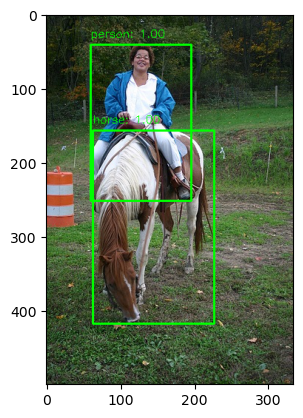

In [93]:
# getting true boxes and labels from the image 
sample_img, ground_annot = sample_data
true_annot = ground_annot["annotation"]["object"]
# getting boxes and labels
true_boxes = [[int(v) for k, v in x["bndbox"].items()] for x in true_annot]
print(f"Total true boxes: {len(true_boxes)}")
print(f"Boxes: {true_boxes}")
true_labels = [obj_to_idx[x["name"]] for x in true_annot]
print(f"Total labels: {true_labels}")
print(true_labels)
scores = [1]*len(labels)

# plot the sample image with ground truth annotations 
annoted_img = draw_boxes_on_image_f(sample_img, true_boxes, true_labels, scores, obj_to_idx, score_threshold=0.5)
plt.imshow(annoted_img)
plt.show()

Type of the image: <class 'PIL.Image.Image'>


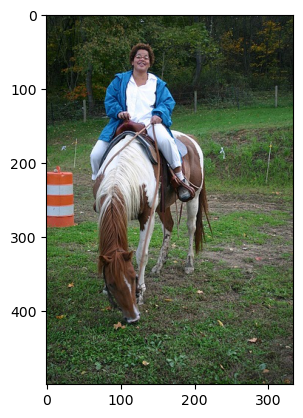

Shape of proposed rectangles after selective search: (300, 4)


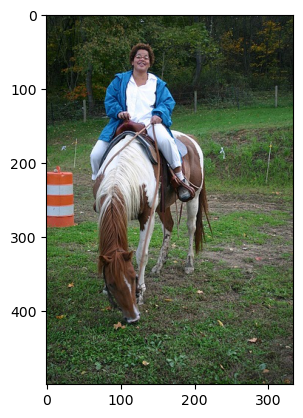

In [94]:
# sample image 
sample_img = sample_data[0]
print(f"Type of the image: {type(sample_img)}")
plt.imshow(sample_img)
plt.show()

# defining image transform to all input images 
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# applying selective search to get region proposals for test image
max_selections = 300
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
# image is in PIL format, therefore, convert it to numpy array 
np_img = np.array(sample_img)
ss.setBaseImage(np_img)
ss.switchToSelectiveSearchFast()
rects = ss.process()[:max_selections]
rects = np.array([[x, y, x+w, y+h] for x, y, w, h in rects])
print(f"Shape of proposed rectangles after selective search: {rects.shape}")
plt.imshow(np_img)
plt.show()

In [95]:
# storing proposed regions and boxes after selective search 
selective_regions = []
proposed_boxes = []

# defining selective regions size
regions_size = (224, 224)

for rect in rects:
    x1, y1, x2, y2 = rect
    img_section = np_img[y1: y2, x1: x2]
    img_section = cv2.resize(img_section, regions_size)
    selective_regions.append(img_section)
    proposed_boxes.append(rect)

print(f"Total selective proposed regions: {len(selective_regions)}")
print(f"Shape of each proposed regions: {selective_regions[0].shape}")
print(f"Total proposed boxes: {len(proposed_boxes)}")
print(f"Proposed boxes shape: {proposed_boxes[0].shape}")

Total selective proposed regions: 300
Shape of each proposed regions: (224, 224, 3)
Total proposed boxes: 300
Proposed boxes shape: (4,)


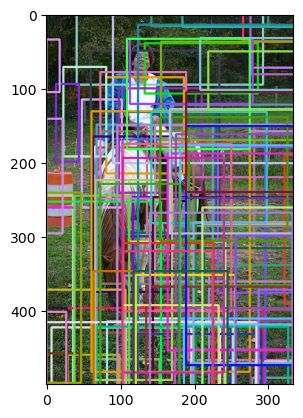

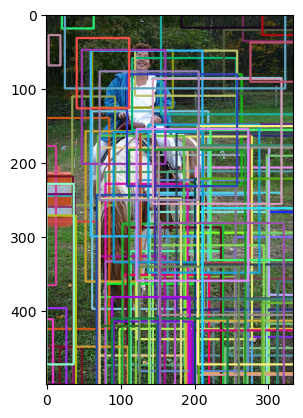

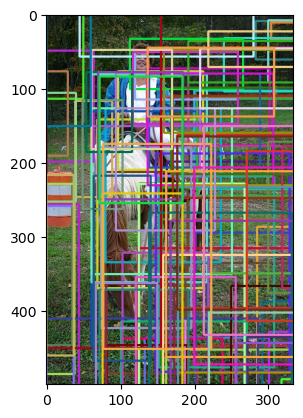

In [96]:
# plotting the input image after applying selective search
import random
for i in range(0, len(rects), 100):
    # clone the original image so we can draw on it
    output = np_img.copy()
    # loop over the current subset of region proposals
    for (x, y, w, h) in rects[i:i + 100]:
        # draw the region proposal bounding box on the image
        color = [random.randint(0, 255) for j in range(0, 3)]
        cv2.rectangle(output, (x, y), (x + w, y + h), color, 2)

    plt.imshow(output)
    plt.show()

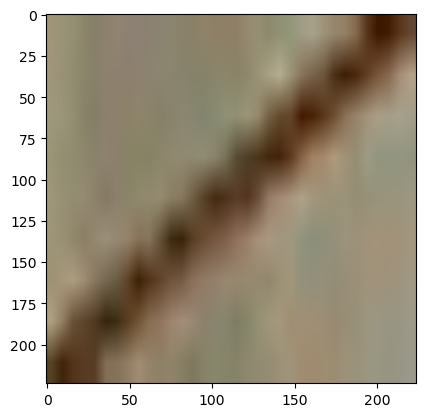

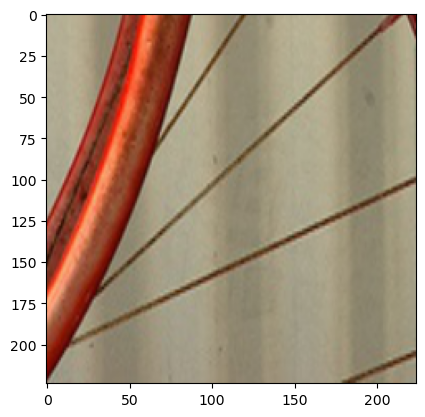

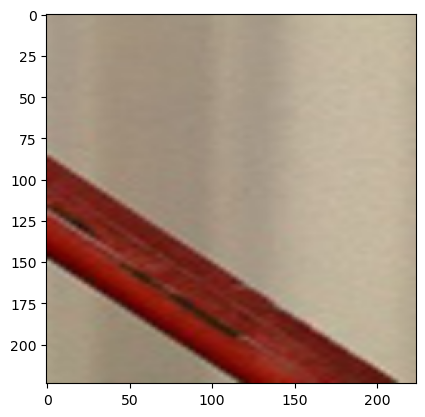

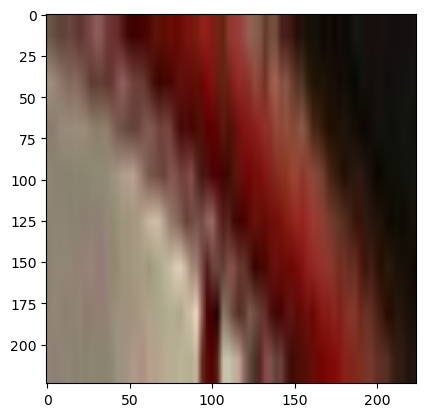

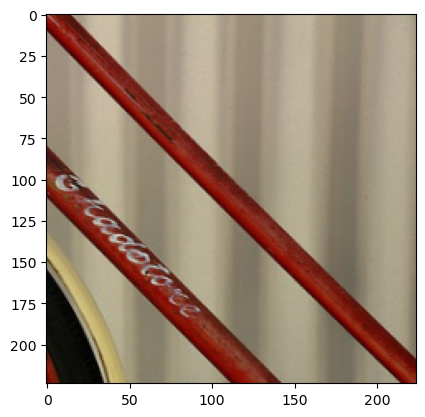

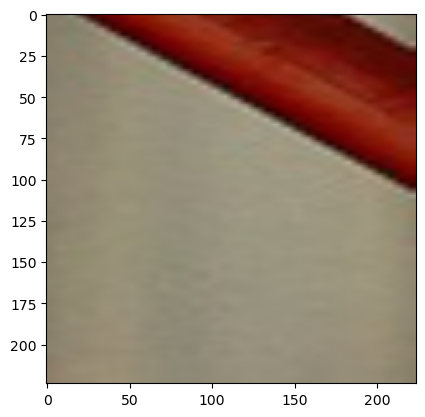

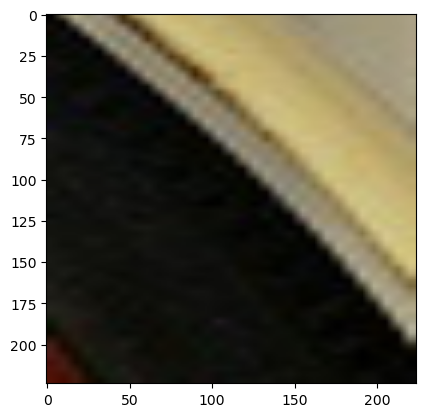

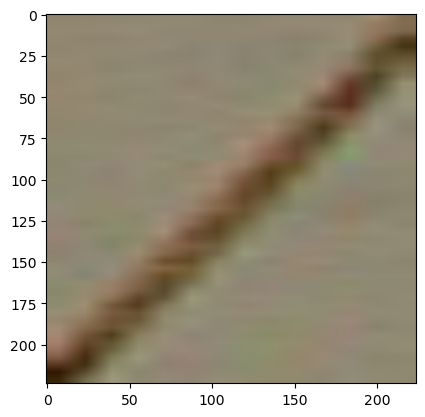

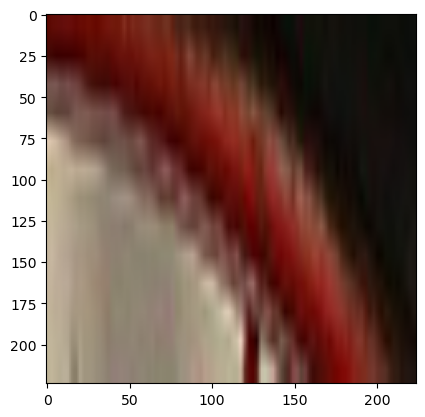

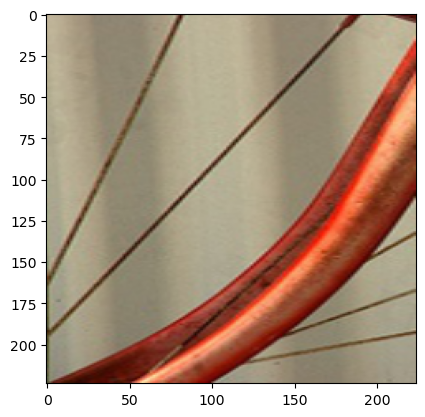

In [38]:
# plotting some proposed regions 
for i in range(0, 50, 5):
    plt.imshow(selective_regions[i])
    plt.show()

In [97]:
# predict through the model 
# to predict, we need input image and set of object proposals, which are bounding boxes of the selected regions 
torch_img = img_transform(sample_img)
print(type(torch_img))
print(f"Shape of the image: {torch_img.shape}")
inp_img = torch_img.unsqueeze(0)
print(f"Shape of the image: {inp_img.shape}")

# converting list to torch 
prop_regions_arr = np.array(proposed_boxes)
prop_regions = torch.tensor(prop_regions_arr, dtype=torch.float32)
prop_regions = prop_regions.unsqueeze(0)
print(f"Type of proposed regions: {type(prop_regions)}")
print(f"Shape of the proposed region boxes: {prop_regions.shape}")

<class 'torch.Tensor'>
Shape of the image: torch.Size([3, 224, 224])
Shape of the image: torch.Size([1, 3, 224, 224])
Type of proposed regions: <class 'torch.Tensor'>
Shape of the proposed region boxes: torch.Size([1, 300, 4])


In [98]:
# Now, we need a forwad pass to get the predicted score and bounding boxes 
# before performing a forward pass, we need to encode those bounding boxes 
# But, unfortunately our model was trained without the bbox offsets, therefore, further experiemnt must be conducted 

# taking inputs to the device 
inp_img = inp_img.to(device)
prop_regions = prop_regions.to(device)

model.eval()
class_scores, bbox_pred = model(inp_img, prop_regions)


In [99]:
print(f"Prediction classes shape: {class_scores.shape}")
print(f"Predcited boxes shape: {bbox_pred.shape}")

Prediction classes shape: torch.Size([300, 21])
Predcited boxes shape: torch.Size([300, 80])


In [100]:
f_scores = torch.argmax(class_scores)
f_scores

tensor(0, device='cuda:0')

In [101]:
# Apply softmax to get class probabilities
prob_scores = F.softmax(class_scores, dim=-1)
    
# Get the predicted class labels and their scores
scores, labels = torch.max(prob_scores, dim=-1)

In [102]:
non_bg_scores = prob_scores[:, 1:]  # Exclude background scores
print("Max non-background score:", non_bg_scores.max().item())
print("Mean non-background score:", non_bg_scores.mean().item())

Max non-background score: 0.01984901912510395
Mean non-background score: 0.0009762960253283381


In [103]:
labels.unique()

tensor([0], device='cuda:0')

In [105]:
# Predicted bounding boxes shape: [100, 80] -> Reshape to [100, 20, 4]
predicted_boxes = bbox_pred.view(300, 20, 4)
print(predicted_boxes.shape)

torch.Size([300, 20, 4])


In [106]:
predicted_boxes[59]

tensor([[ 8.2453e-03,  1.0502e-02, -6.0313e-03,  7.4305e-02],
        [ 2.5943e-03, -1.7730e-02,  7.7254e-04,  1.4832e-01],
        [-9.3766e-03, -1.3702e-04,  2.7615e-02,  2.9495e-02],
        [ 4.2366e-03,  1.2546e-02,  4.8142e-02,  7.5848e-02],
        [ 4.4324e-04,  7.3182e-03,  5.1296e-02,  7.5387e-02],
        [-1.8974e-04,  5.3543e-03,  4.7430e-02,  2.3594e-02],
        [-1.6881e-02,  2.2843e-02,  2.8989e-02,  7.5019e-02],
        [ 2.0168e-03,  1.0424e-02,  1.0166e-03,  7.8416e-02],
        [-1.1746e-03,  1.1986e-02,  2.2073e-02,  7.1099e-02],
        [ 3.5213e-03, -6.7576e-03,  3.6976e-02,  6.1687e-02],
        [ 3.9796e-03,  1.1535e-02,  1.5962e-02,  5.1122e-02],
        [ 9.7373e-03,  2.3563e-02,  4.7324e-02,  8.8625e-02],
        [ 8.0952e-03,  2.2908e-02,  3.3088e-02,  9.0167e-02],
        [ 7.7314e-03, -1.9098e-02, -6.3882e-02,  1.1905e-01],
        [ 6.5018e-03,  6.9774e-03,  8.2460e-04,  6.6260e-02],
        [ 1.2617e-03,  3.1446e-03,  5.2158e-02,  4.5641e-02],
        

In [107]:
# Note: labels range from 0 (background) to 20
selected_boxes = predicted_boxes[torch.arange(300), labels - 1]

In [108]:
selected_boxes.shape

torch.Size([300, 4])

In [109]:
selected_boxes

tensor([[ 0.0073, -0.0150, -0.0209,  0.1308],
        [ 0.0073, -0.0150, -0.0209,  0.1308],
        [ 0.0073, -0.0150, -0.0209,  0.1308],
        ...,
        [ 0.0073, -0.0150, -0.0209,  0.1308],
        [ 0.0073, -0.0150, -0.0209,  0.1308],
        [ 0.0073, -0.0150, -0.0209,  0.1308]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [90]:
non_background_mask = labels > 0  # Only non-background labels
selected_boxes_2 = predicted_boxes[non_background_mask]

In [91]:
selected_boxes_2

tensor([], device='cuda:0', size=(0, 20, 4), grad_fn=<IndexBackward0>)